# Biased Noise Fluxonium 

In [27]:
nlev_lc = 30
nlev_single = 7  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L1 = 0.8  # inductive energy
    E_C1 = 1.0  # charging energy
    E_J1 = 6.8  # Josephson energy
    phi_ext1 = np.pi  # external phase shift

    # Parameters of the second fluxonium.
    E_L2 = 1  # inductive energy
    E_C2 = 1.0  # charging energy
    E_J2 = 7  # Josephson energy
    phi_ext2 = np.pi  # external phase shift

    # Interaction energy between two fluxoniums.
    # E_int n_1 n_2 or E_int phi_1 phi_2.
    E_int = 0.27  # when a single value is needed
    E_int_range = np.linspace(0, 0.3, 11)  # when a range is needed
    coupling_type = 'charge'  # 'charge' or 'flux'

qubit1 = fluxonium.Fluxonium(E_J = E_J1, E_C=E_C1, E_L=E_L1, phi_ext=phi_ext1, nlev = nlev_single, nlev_lc = nlev_lc)
qubit2 = fluxonium.Fluxonium(E_J = E_J2, E_C=E_C2, E_L=E_L2, phi_ext=phi_ext2, nlev = nlev_single, nlev_lc = nlev_lc)
print("Qubit A: %s" % (qubit1))
print("Qubit B: %s" % (qubit2))

Qubit A: A fluxonium qubit with E_L = 0.8 GHz, E_C = 1.0 GHz, and E_J = 6.8 GHz. The external phase shift is phi_ext/pi = 1.0.
Qubit B: A fluxonium qubit with E_L = 1 GHz, E_C = 1.0 GHz, and E_J = 7 GHz. The external phase shift is phi_ext/pi = 1.0.


## Uncoupled basis

In [20]:
phi_pts = np.linspace(0, 1, 1001)*np.pi*2
energies1 = np.zeros((nlev_single, len(phi_pts)))
energies2 = np.zeros_like(energies1)
n1_01 = np.zeros_like(phi_pts, dtype = complex)
n2_01 = np.zeros_like(phi_pts, dtype = complex)
phi1_01 = np.zeros_like(phi_pts, dtype = complex)
phi2_01 = np.zeros_like(phi_pts, dtype = complex)

for iphi, phi_ext in enumerate(phi_pts):
    qubit1.phi_ext = phi_ext
    qubit2.phi_ext = phi_ext
    energies1[:, iphi] = qubit1.levels(nlev=nlev_single)
    energies2[:, iphi] = qubit2.levels(nlev=nlev_single)
    n1_01[iphi] = qubit1.n_ij(level1=0,level2=1)
    n2_01[iphi] = qubit2.n_ij(level1=0,level2=1)
    phi1_01[iphi] = qubit1.phi_ij(level1=0,level2=1)
    phi2_01[iphi] = qubit2.phi_ij(level1=0,level2=1)

Text(0, 0.5, 'Frequency (GHz)')

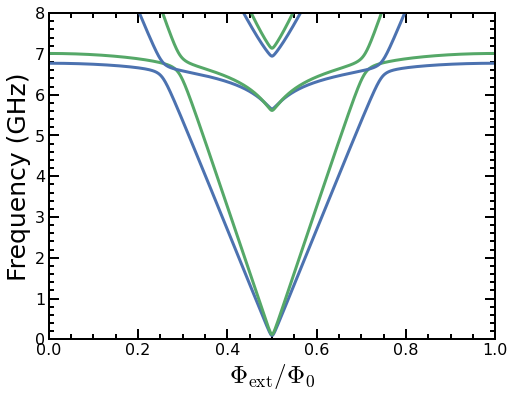

In [25]:
plt.figure(figsize = [8,6])
for idx in range(1,7):
    plt.plot(phi_pts/(np.pi*2), energies1[idx, :] - energies1[0, :], color='C0')
    plt.plot(phi_pts/(np.pi*2), energies2[idx, :] - energies2[0, :], color='C1')
plt.xlim([phi_pts[0]/(np.pi*2), phi_pts[-1]/(np.pi*2)])
plt.ylim([0, 8])
plt.xlabel(r'$\Phi_\mathrm{ext}/\Phi_0$')
plt.ylabel('Frequency (GHz)')

## Fix flux, sweep coupling

In [86]:
#Sweep the coupling strength, charge
E_int_array = np.linspace(0, 0.5, 501)
phi_ext = 0.42*2*np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = 0.3*2*np.pi
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev, len(E_int_array)))

for idx, E_int in enumerate(E_int_array):
    system = coupobj.CoupledObjects(qubit1, qubit2,
                                    [qubit1, qubit2, E_int, coupling_type])
    energies_coupled_swE[:,idx] = system.levels()

(0.0, 0.5)

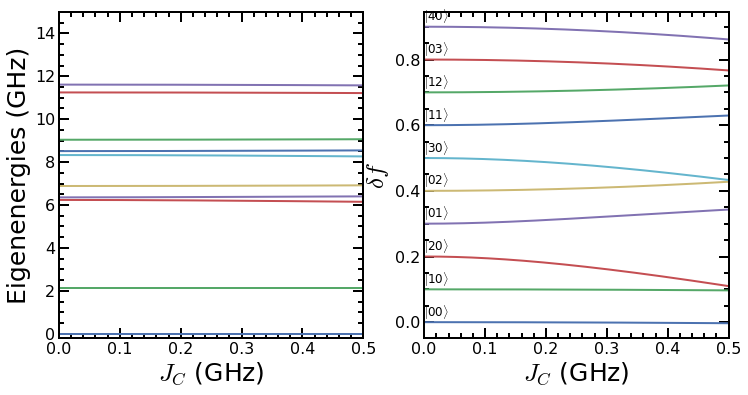

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [12,6])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
nlev_show = 10

#Transition freqs
for idx in range(0, nlev_show):
    ax1.plot(E_int_array, energies_coupled_swE[idx, :]-energies_coupled_swE[0, :], linewidth = 2.0)
ax1.set_xlabel('$J_C$ (GHz)')
ax1.set_ylabel('Eigenenergies (GHz)')
ax1.set_xlim([E_int_array[0], E_int_array[-1]])
ax1.set_ylim([-0.2,15])

#State labeling
for idx in range(0, nlev_show):
    ax2.plot(E_int_array, 0.1 * idx+(energies_coupled_swE[idx, :]-energies_coupled_swE[idx, 0]), linewidth = 2.0)
    label = (r'$|$' + system.level_label(idx, label_format='str') + r'$\rangle$')
    ax2.text(0, 0.02 + 0.1 * idx, label, fontsize=12)
ax2.set_xlabel('$J_C$ (GHz)')
ax2.set_ylabel(r'$\delta f$')
ax2.set_xlim([E_int_array[0], E_int_array[-1]])

(0.0, 500.0)

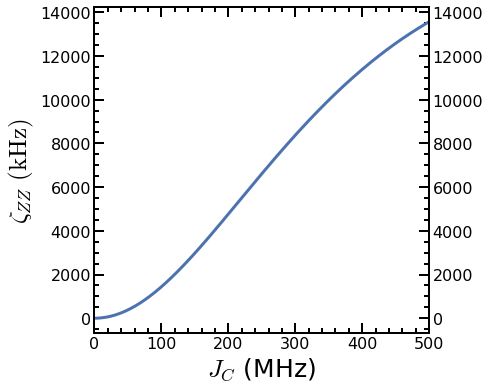

In [88]:
#Calculate ZZ rate:
plt.figure(figsize = [6,6])
zeta_ZZ = energies_coupled_swE[system.level_label('11'),:] - energies_coupled_swE[system.level_label('01'),:] \
- (energies_coupled_swE[system.level_label('10'), :] - energies_coupled_swE[system.level_label('00'), :])
freq_shift = energies_coupled_swE[system.level_label('10'), :] - energies_coupled_swE[system.level_label('00'), :]
freq_shift = freq_shift - (energies_coupled_swE[system.level_label('10'), 0] - energies_coupled_swE[system.level_label('00'), 0])
plt.plot(E_int_array*1e3, abs(zeta_ZZ)*1e6, label = r'$\zeta_{ZZ}$')
# plt.plot(E_int_array*1e3, abs(freq_shift)*1e3, label = r'$\delta f _{|10\rangle - |00\rangle}$')
# plt.legend()
plt.tick_params(left=True, right=True,labelleft=True, labelright=True)
plt.ylabel(r'$\zeta_{ZZ}~\mathrm{(kHz)}$')
plt.xlabel('$J_C$ (MHz)')
plt.xlim([E_int_array[0]*1e3, E_int_array[-1]*1e3])

## Fix flux and coupling of 1 qubit, sweep flux of other qubit

In [79]:
#Sweep the coupling strength, charge
E_int = 0.2
phi_ext_A = 0.42*2*np.pi
phi_ext_array = np.linspace(0.0,0.5,101)*2*np.pi
qubit1.phi_ext = phi_ext_A
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev, len(phi_ext_array)))

for idx, phi_ext_B in enumerate(phi_ext_array):
    qubit2.phi_ext = phi_ext_B
    system = coupobj.CoupledObjects(qubit1, qubit2,
                                    [qubit1, qubit2, E_int, coupling_type])
    energies_coupled_swE[:,idx] = system.levels()

Text(0.5, 0, '$\\Phi^B_\\mathrm{ext}/\\Phi_o$')

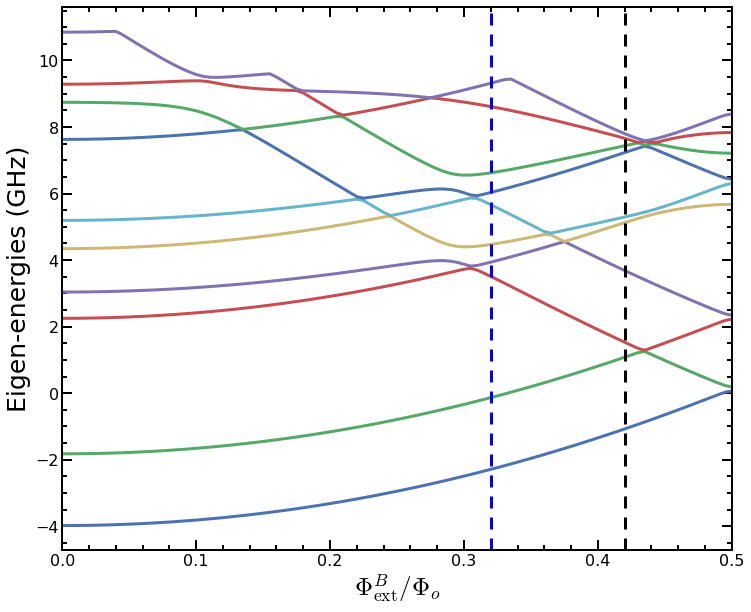

In [82]:
plt.figure(figsize = [12,10])
for idx in range(nlev_show):
    plt.plot(phi_ext_array/2/np.pi, energies_coupled_swE[idx,:])
plt.axvline(x = 0.42, color = 'k', linestyle = '--')
plt.axvline(x = 0.32, color = 'b', linestyle = '--')
plt.xlim([phi_ext_array[0]/2/np.pi, phi_ext_array[-1]/2/np.pi])
plt.ylabel('Eigen-energies (GHz)')
plt.xlabel(r'$\Phi^B_\mathrm{ext}/\Phi_o$')

Text(0, 0.5, '$\\zeta_{ZZ}~\\mathrm{(kHz)}$')

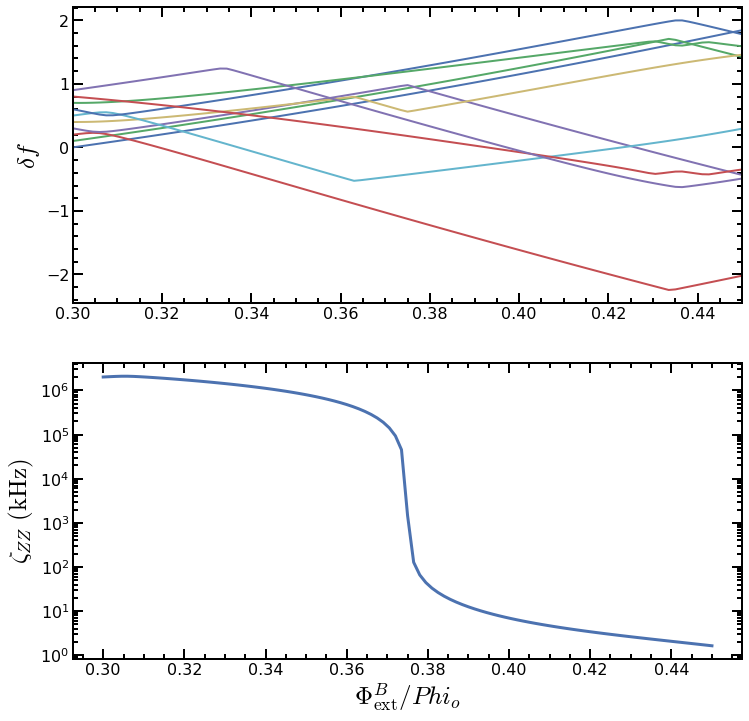

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = [12,12])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
nlev_show = 10

#State labeling
for idx in range(0, nlev_show):
    ax1.plot(phi_ext_array/2/np.pi, 0.1 * idx+(energies_coupled_swE[idx, :]-energies_coupled_swE[idx, 0]), linewidth = 2.0)
    label = (r'$|$' + system.level_label(idx, label_format='str') + r'$\rangle$')
#     ax1.text(0, 0.02 + 0.1 * idx, label, fontsize=12)
ax2.set_xlabel(r'$\Phi^B_\mathrm{ext}/Phi_o$')
ax1.set_ylabel(r'$\delta f$')
ax1.set_xlim([phi_ext_array[0]/2/np.pi, phi_ext_array[-1]/2/np.pi])

#ZZ rate
zeta_ZZ = energies_coupled_swE[system.level_label('11'),:] - energies_coupled_swE[system.level_label('01'),:] \
- (energies_coupled_swE[system.level_label('10'), :] - energies_coupled_swE[system.level_label('00'), :])
ax2.semilogy(phi_ext_array/2/np.pi, abs(zeta_ZZ)*1e6, label = r'$\zeta_{ZZ}$')
ax2.set_ylabel(r'$\zeta_{ZZ}~\mathrm{(kHz)}$')